In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
# Connect to the MySQL database
db = mysql.connector.connect(
    host='localhost',
    user='root',
    password='W7301@jqir#',
    database='ecommerce'
)
cur=db.cursor()

# List all unique cities where customers are located

In [40]:
query= """ select distinct customer_city from customers"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data)
df

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
...,...
4114,siriji
4115,natividade da serra
4116,monte bonito
4117,sao rafael


# Count the number of orders placed in 2017

In [9]:
query= """ select count(order_id) from orders where year(order_purchase_timestamp)=2017 """
cur.execute(query)
data=cur.fetchall()
"total orders placed in 2017 are" ,data[0][0]

('total orders placed in 2017 are', 45101)

# Find total sales per category

In [14]:
query="""select lower(products.product_category) category,round(sum(payments.payment_value),2) sales
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id= order_items.order_id
group by category

"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data, columns=["Category","Sales"])
df

,Category,Sales
0,perfumery,506738.66
1,furniture decoration,1430176.39
2,telephony,486882.05
3,bed table bath,1712553.67
4,automotive,852294.33
...,...,...
69,cds music dvds,1199.43
70,la cuisine,2913.53
71,fashion children's clothing,785.67
72,pc gamer,2174.43


 # Calculate the percentage of orders that were paid in installments

In [28]:
query=""" select (sum(case when payment_installments >= 1 then 1 else 0 end))/count(*)*100 from payments
"""
cur.execute(query)
data=cur.fetchall()
"the total percentage of order placed in installments are", data[0][0]

('the total percentage of order placed in installments are',
 Decimal('99.9981'))

# Count the number of customers from each state 

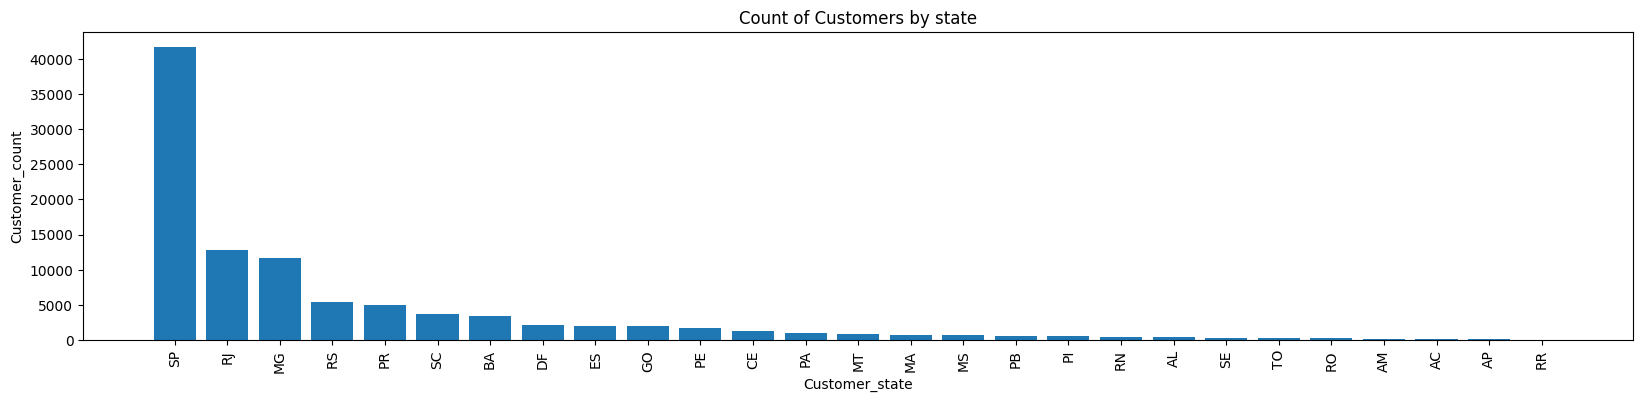

In [53]:
query=""" select customer_state,count(customer_id) from customers group by customer_state
"""
cur.execute(query)
data=cur.fetchall() 
df=pd.DataFrame(data, columns=["Customer_state","Customer_count"])
df=df.sort_values(by="Customer_count", ascending= False)
plt.figure(figsize=(20,4))
plt.bar(df["Customer_state"],df["Customer_count"])
plt.xticks(rotation=90)
plt.xlabel("Customer_state")
plt.ylabel("Customer_count")
plt.title("Count of Customers by state")
plt.show()

# Calculate number of orders per month in 2018

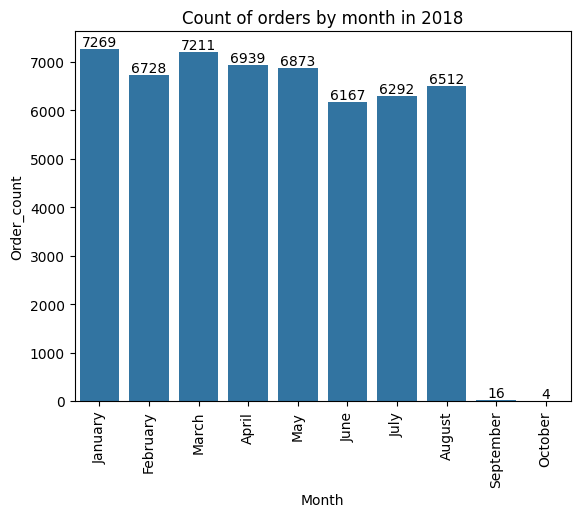

In [54]:
query=""" select monthname(order_purchase_timestamp) month,count(order_id) order_count from orders
where year(order_purchase_timestamp)=2018 
group by month
"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data, columns=["Month","Order_count"])
df
o=["January", "February" ,"March", "April", "May","June", "July", "August", "September", "October"]
labeldata=sns.barplot(x= df["Month"],y= df["Order_count"], data=df, order=o)
plt.xticks(rotation=90)
labeldata.bar_label(labeldata.containers[0])
plt.title("Count of orders by month in 2018")
plt.show()

# Find the average number of orders per product, grouped by customer city in descending order of average orders

In [61]:
query=""" with count_per_order as
(select orders.order_id, orders.customer_id , count(order_items.order_id) ord 
from orders join order_items
on orders.order_id= order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city,  round(avg(count_per_order.ord),2) average_orders
from customers join count_per_order
on customers.customer_id=count_per_order.customer_id
group by customers.customer_city order by average_orders desc
"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data, columns=["Customer_city","Average_orders"])
df

,Customer_city,Average_orders
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
...,...,...
4105,lagoa da canoa,1.00
4106,japaratuba,1.00
4107,sebastiao leal,1.00
4108,morro agudo de goias,1.00


# Calculate percentage of total revenue contributed by each product category

In [66]:
query="""select lower(products.product_category) category,round(((sum(payments.payment_value))/(select sum(payment_value) from payments))*100,2) sales_percent
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id= order_items.order_id
group by category order by sales_percent 

"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data, columns=["Category","Sales_percent"])
df

,Category,Sales_percent
0,insurance and services,0.00
1,fashion children's clothing,0.00
2,arts and crafts,0.01
3,flowers,0.01
4,pc gamer,0.01
...,...,...
69,furniture decoration,8.93
70,watches present,8.93
71,computer accessories,9.90
72,health beauty,10.35


# Identify correlation between product price and the number of times a product has been purchased

In [74]:
import numpy as np
query=""" select products.product_category, count(order_items.product_id),round(avg(order_items.price),2)
from products join order_items
on products.product_id =order_items.product_id
group by products.product_category"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data, columns=["Category","Count", "Sales_average"])
df
array1=df["Count"]
array2=df["Sales_average"]
cor=np.corrcoef([array1,array2])
corr=round(cor[0][1],2)
print("the correlation between product price and the number of times a product has been purchased",corr )
if (corr>-0.5 and  corr <0.5):
    print("There is no correlation")
elif (corr >=0.5):
    print("There is positive correlation")
else:
    print(" There is negative correlation")

the correlation between product price and the number of times a product has been purchased -0.11
There is no correlation


# Calculate total revenue generated by each seller, and rank them by revenue

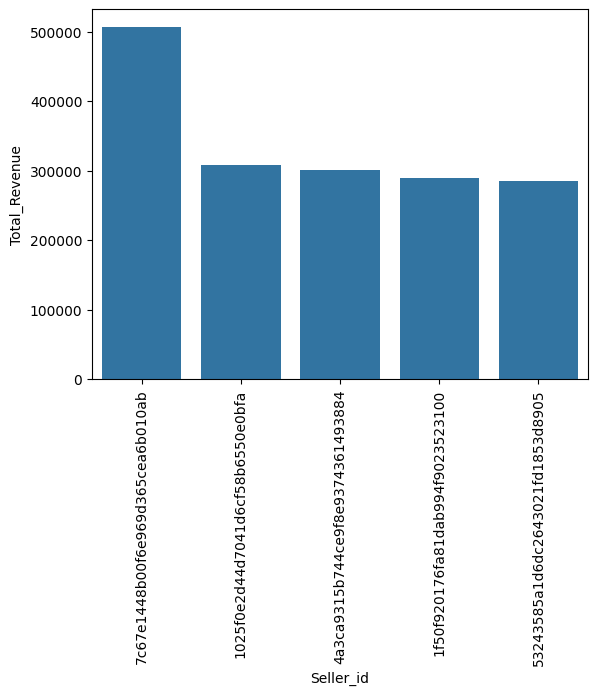

In [14]:
query=""" select *, dense_rank() over(order by revenue desc) as rank_revenue from
(select order_items.seller_id, sum(payments.payment_value) revenue
from payments join order_items
on payments.order_id =order_items.order_id
group by order_items.seller_id) as tab"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data, columns=["Seller_id","Total_Revenue", "Rank"])
df.head()
sns.barplot(x="Seller_id",y="Total_Revenue",data=df.head())
plt.xticks(rotation=90)
plt.show()

# Calculate moving average of order values for each customer over their order history

In [16]:
query=""" select customer_id, order_purchase_timestamp, payment ,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp,
payments.payment_value as payment
from payments join orders
on payments.order_id =orders.order_id) as a  """
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data, columns=["Customer_id","order_purchase_timestamp", "payment","moving average"])
df.head()

,Customer_id,order_purchase_timestamp,payment,moving average
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002


# Calculate cumulative sales per month for each year

In [20]:
query=""" select years,month, sum(payment)
over(order by years,month) from
(select year(orders.order_purchase_timestamp) as years, month(orders.order_purchase_timestamp) as month,
round(sum(payments.payment_value),2) as payment from orders join payments 
on orders.order_id=payments.order_id 
group by years, month order by years,month) as a"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data, columns=["Year","Month", "Cumulative Sale"])
df.head()

,Year,Month,Cumulative Sale
0,2016,9,252.24
1,2016,10,59342.72
2,2016,12,59362.34
3,2017,1,197850.38
4,2017,2,489758.39


# Calculate the year_over_year growth rate of total sales

In [23]:
query="""with a as (select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments 
on orders.order_id=payments.order_id 
group by years order by years)
select years, payment,lag(payment,1) over(order by years) previous_year ,
((payment-lag(payment,1) over(order by years))/lag(payment,1) over(order by years))*100 from a"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data, columns=["Year","Sale","previous_year","Year_over_Year_Growth_Rate"])
df.head()

,Year,Sale,previous_year,Year_over_Year_Growth_Rate
0,2016,59362.34,NaN,NaN
1,2017,7249746.73,59362.34,12112.703761
2,2018,8699763.05,7249746.73,20.000924


# Identify top 3 customers who spent the most money in each year.


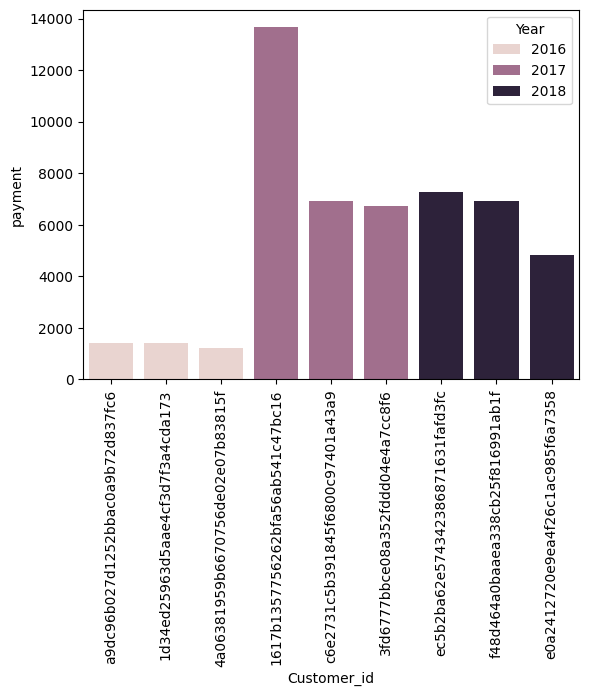

In [26]:
query="""select years, customer_id, payment,d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over (partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments
on payments.order_id=orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank<=3"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data, columns=["Year","Customer_id","payment","Rank"])
sns.barplot(x="Customer_id", y="payment", data=df, hue= "Year")
plt.xticks(rotation=90)
plt.show()